In [122]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import random
import numpy as np

# Basic Audio Processing
In this notebook we'll get the basics of our audio processing down.  Our goals:
 1. Load audio files
 2. Convert audio files to vectors
 3. Plot spectrograms of audio files
 4. Create an abstraction for our datasets of speakers and utterances
 5. Play audio files as a widget
 

## Dataset
We're using the [VoxCeleb1 Dataset](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html).  You can find download instructions there.

A quick note: when you download the files, you'll get about 5 files, which you'll need to concatenate together to unzip.  To do this in windows, use:
```
  copy /b a.zip+b+c+d vox1.zip
```

## Load audio file

In [90]:
def load_wav(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

In [91]:
wav_fnam=r'D:\datasets\voxceleb1\vox1_test_wav\wav\id10285\m-uILToQ9ss\00004.wav'
wav = load_wav(wav_fnam)
wav

(16000, array([-666, -607, -295, ...,  196,  159,   43], dtype=int16))

## Plot Spectrogram

In [75]:
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def graph_audio(wav_file):
    rate, samples = get_wav_info(wav_file)
    plt.figure(1)    
    a = plt.subplot(211)    
    a.set_xlabel('time [s]')    
    a.set_ylabel('value [-]')    
    plt.plot(samples)
    c = plt.subplot(212)
    Pxx, freqs, bins, im = c.specgram(samples, NFFT=1024, Fs=16000, noverlap=900)    
    c.set_xlabel('Time')    
    c.set_ylabel('Frequency')    
    plt.show()

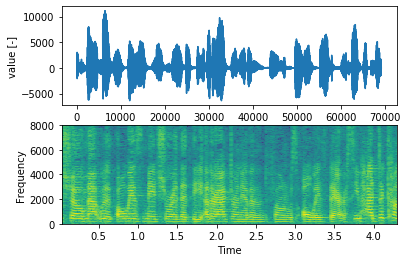

In [92]:
graph_audio(wav_fnam)

## Audio Database
Let's make a standard interface for dealing with our audio samples.

Our sample data is structured with one directory per speaker, with the speaker id as the name of the folder.
Within each folder is multiple directories, each containing audio clips from that speaker.

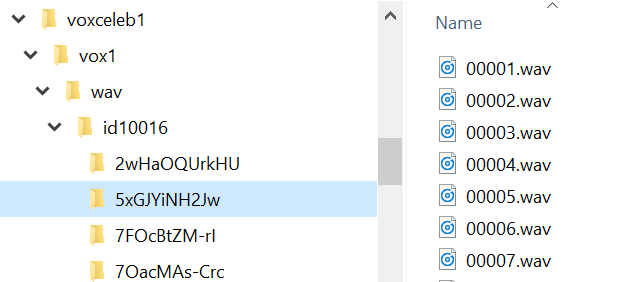

In the above example, we can see several samples for speaker 'id10016'.

In [46]:
class SpeakerDatabase:
    def __init__(self, directory):
        """
        directory: path name of the root directory.
        This directory should contain directories named by the speaker ids.
        """
        self.directory = directory
        self.speaker_ids = os.listdir(self.directory)
        if not self.speaker_ids:
            raise Exception('Speaker database at %s should contain folders named by speaker id')
    
    def random_speaker(self):
        """Returns the id of a random speaker."""
        return random.choice(self.speaker_ids)
    
    def random_wav(self):
        """Selects a random speaker, then returns a random utterance from that speaker.
        returns speaker_id, wav_filename.
        """
        speaker_id = self.random_speaker()
        wav_filename = self.random_wav_for_speaker(speaker_id)
        return speaker_id, wav_filename

    def random_wav_for_speaker(self, speaker_id):
        speaker_root = os.path.join(self.directory, speaker_id)
        speaker_files = []
        for root, dirs, filenames in os.walk(speaker_root):
            for partial_fnam in filenames:
                filename = os.path.join(root, partial_fnam)
                speaker_files.append(filename)
        return random.choice(speaker_files)
    
    def random_triplet(self):
        """Selects a triplet of audio samples. Two from the same speaker, and one from a different speaker.
        Returns filenames: anchor, positive, negative.
        anchor: A wav filename with an audio sample for the "anchor" speaker, which will match the positive example.
        positive: A wave filename with an audio sample for the "positive" speaker, which is from the same speaker as the anchor.
        negative: A wave filename with an audio sample from a different speaker from the anchor.
        """
        anchor_id, anchor_wav = self.random_wav()
        while True:
            positive_wav = self.random_wav_for_speaker(anchor_id)
            if positive_wav != anchor_wav:
                break
        while True:
            negative_id, negative_wav = self.random_wav()
            if negative_id != anchor_id:
                break
        return anchor_wav, positive_wav, negative_wav

In [93]:
test_db_path = r'D:\datasets\voxceleb1\vox1_test_wav\wav'
test_db = SpeakerDatabase(test_db_path)

In [94]:
[test_db.random_speaker() for x in range(5)]

['id10305', 'id10277', 'id10301', 'id10299', 'id10300']

In [49]:
test_db.random_wav()

('id10308',
 'D:\\datasets\\voxceleb1\\vox1_test_wav\\wav\\id10308\\rgpPBT4yQcg\\00013.wav')

In [50]:
test_db.random_triplet()

('D:\\datasets\\voxceleb1\\vox1_test_wav\\wav\\id10297\\kWOMY99knWI\\00002.wav',
 'D:\\datasets\\voxceleb1\\vox1_test_wav\\wav\\id10297\\utAY0zpsv1U\\00009.wav',
 'D:\\datasets\\voxceleb1\\vox1_test_wav\\wav\\id10304\\zV7LlMi0eHo\\00011.wav')

## Display Audio

In [95]:
import IPython

def display_audio(filename):
    """Present a UI width to play audio."""
    return IPython.display.Audio(filename)

def display_audio_list(filenames):
    """Present a UI for multiple filenames"""
    display_objects = [display_audio(x) for x in filenames]
    [IPython.display.display(obj) for obj in display_objects]

In [96]:
triplet = test_db.random_triplet()
display_audio_list(triplet)

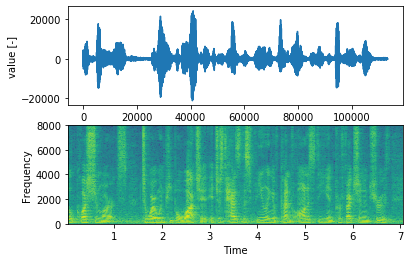

In [97]:
graph_audio(triplet[2])

# Library
We've packaged the useful parts of this into voicelib.py:
 * load_wav
 * graph_spectrogram
 * graph_audio

## Diving into Spectrograms
The [Matplotlib.specgram function](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.specgram.html) actually calculates a machine-readable spectogram and does all the FFT's for us. Let's look into the data it returns.

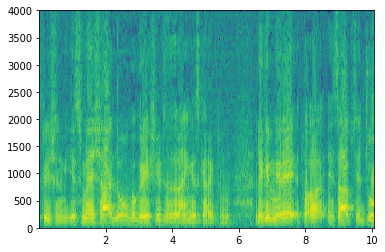

In [112]:
spectrum = graph_spectrogram(triplet[0])

In [102]:
spectrum.shape

(101, 1006)

The *spectrum* variable is the first of the values returned from matplotlib.specgram, and is a 2d matrix.  Rows are different frequencies, and columns are time slices.

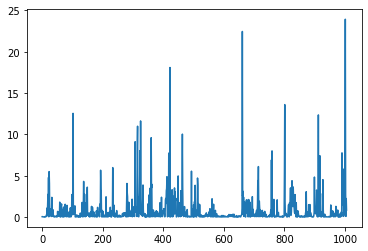

In [108]:
plt.plot(spectrum[0]) # Plot over time of the lowest frequency band.

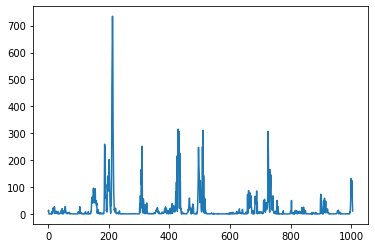

In [109]:
plt.plot(spectrum[20]) # Plot over time of another frequency band.

## Feeding Spectrograms into Models

In [126]:
def predict(filename):
    x = graph_spectrogram(filename) # Returns rows=frequencies, cols=time bands
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)           # Now x is (time bands, frequencies)
    # model.predict(X) can predict m samples at once, so we need to pack in another dimension.
    x = np.expand_dims(x, axis=0)  # Now x is has an extra dimension for a single sample, m=1.
    predictions = model.predict(x)

In [113]:
spectrum.shape

(101, 1006)

In [116]:
swapped = spectrum.swapaxes(0,1)

In [118]:
swapped.shape


(1006, 101)

In [123]:
a = np.array([[1,2,3],[4,5,6]])

In [124]:
a.swapaxes(0,1)

array([[1, 4],
       [2, 5],
       [3, 6]])

In [125]:
np.expand_dims(a, axis=0)

array([[[1, 2, 3],
        [4, 5, 6]]])